# Quantum Phase Estimation
### and estimating pi with QPE

### Sources: Qiskit textbook and 2020 Qiskit Global Summer School

#### From Qiskit textbook

- **Quantum phase estimation**: https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html
- **Quantum Fourier transform**: https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html
- **Pi estimation**: https://qiskit.org/textbook/ch-demos/piday-code.html

#### 2020 Qiskit Global Summer School:
https://qiskit.org/learn/summer-school/introduction-to-quantum-computing-and-quantum-hardware-2020/

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Installing necessary packages

In [2]:
!pip install -U -r resources/requirements.txt

from IPython.display import clear_output
clear_output()

# Quantum Phase Estimation Circuit

![image](resources/qpe.png)


The goal of quantum phase estimation is to determine the phase $\theta$ applied by a unitary operator $U$ on its eigenstate $\vert\psi\rangle$,

$$U\vert\psi\rangle = e^{2\pi i\theta}\vert\psi\rangle$$

1. Begin by creating a superposition of all $2^n$ computational basis states on the $n$ measurement qubits by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. We also initialize the target qubits (in this case only one) into an eigenstate $\vert\psi\rangle$ of the unitary operator $U$.

2. Second, apply the unitary operator $U$ with various powers onto the target qubits (in this case only one) by controlling it with each of the different measurement qubits. The schematic above shows the ordering and respective powers.

3. Third, apply an inverse quantum Fourier transform on the $n$ measurement qubits.

4. Finally, measure the $n$ qubits and read out $2^n\theta$.


## Problem: Implement the unitary operator $U$ of a single qubit given by

$$U = \begin{bmatrix}1 & 0\\ 0 & e^{2\pi i\theta}\end{bmatrix}$$

for which an eigenstate is the single-qubit state $\vert1\rangle$. The operator applies a phase

$$U\vert1\rangle = e^{2\pi i\theta}\vert1\rangle$$

Objective is to determine theta using quantum phase estimation.
Use $\theta=0.5$ and $n = 5$ measurement qubits.

### 1. Initializing the qubits

Initialize qubits as described above by applying a Hadamard gate on each of the $n$ measurement qubits. Also set the target qubit to $\vert1\rangle$, since that is the eigenstate onto which the unitary operator $U$ will be applied. 

In [3]:
def initialize_qubits(circuit, measurement_qubits, target_qubit):
    
    # Hadamard on measurement qubits
    circuit.h(measurement_qubits)
        
    # Set taget qubit to 1 (eigenstate of the unitary above)
    circuit.x(target_qubit)
    
    return circuit     

### 2. Implementing the unitary operator

The function defined below implements the unitary operator described above by using `Qiskit`'s controlled-phase gate. The matrix for the $CP$ gate is

$$CPhase = I\otimes\vert0\rangle\langle0\vert+P\otimes\vert1\rangle\langle1\vert 
=\begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}$$

**Note that the phase from the $CP$ (or P) gate differs from that of the $U$ gate by a factor of $2\pi$. Do account for this difference.**

In [4]:
import numpy as np
pi = np.pi

In [5]:
def unitary_operator(circuit, control_qubit, target_qubit, theta):
    
    circuit.cp(2*pi*theta,control_qubit,target_qubit)
    
    return circuit

Need to apply different powers of the unitary operator for the quantum phase estimation algorithm. In order to do this,  either create a loop that applies that operator several times, or take advantage of the fact that the matrix for $CP$ is diagonal, and simply multiply the phase by the power.

In [6]:
def unitary_operator_exponent(circuit, control_qubit, target_qubit, theta, exponent):
    
    circuit.cp(2*pi*theta*exponent,control_qubit,target_qubit)
    
    return circuit
    

In [7]:
def unitary_operator_pi_exponent(circuit, control_qubit, target_qubit, exponent):
    # specific instance of function unitary_operator_exponent() with theta=1,
    # used for pi estimation code
    
    for i in range(exponent):
        circuit.cp(1,control_qubit,target_qubit)
    
    return circuit

### 3. Implementing an inverse quantum Fourier transform

Use `Qiskit`'s circuit library to give a box that implements the inverse quantum fourier transform. Use`qiskit.circuit.library.qft(num_qubits).inverse()`.

Doc: https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html

In [19]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from qiskit.circuit.library import QFT

In [9]:
def apply_iqft(circuit, measurement_qubits, n):
    
    circuit.append(QFT(n).inverse(), measurement_qubits)
    
    return circuit

### 4. Putting it all together

In [10]:
from qiskit import QuantumCircuit

In [11]:
def QPE(n, theta):
    
    # Create a quantum circuit on n+1 qubits (n measurement, 1 target)
    qc = QuantumCircuit(n+1, n)
    
    # Initialize the qubits
    initialize_qubits(qc, range(n), n)
    
    # Apply the controlled unitary operators in sequence
    for x in range(n):
        exponent = 2**(n-x-1)
        unitary_operator_exponent(qc, x, n, theta, exponent)
        
    # Apply the inverse quantum Fourier transform
    apply_iqft(qc, range(n), n)
    
    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

In [12]:
def QPE_pi(n):
    # An instance of function QPE(), with theta=1,
    # for pi estimation code
    
    # Create a quantum circuit on n+1 qubits (n measurement, 1 target)
    qc = QuantumCircuit(n+1, n)
    
    # Initialize the qubits
    initialize_qubits(qc, range(n), n)
    
    # Apply the controlled unitary operators in sequence
    for x in range(n):
        exponent = 2**(n-x-1)
        unitary_operator_pi_exponent(qc, x, n, exponent)
        
    # Apply the inverse quantum Fourier transform
    apply_iqft(qc, range(n), n)
    
    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

In [13]:
warnings.filterwarnings('ignore')
n = 5; theta = 0.5
circuit = QPE(n, theta)
circuit.draw(output='text')


┌───┐                                                  ┌───────┐┌─┐      »
q_0: ┤ H ├─────■────────────────────────────────────────────┤0      ├┤M├──────»
     ├───┤     │                                            │       │└╥┘┌─┐   »
q_1: ┤ H ├─────┼─────────■──────────────────────────────────┤1      ├─╫─┤M├───»
     ├───┤     │         │                                  │       │ ║ └╥┘┌─┐»
q_2: ┤ H ├─────┼─────────┼─────────■────────────────────────┤2 iqft ├─╫──╫─┤M├»
     ├───┤     │         │         │                        │       │ ║  ║ └╥┘»
q_3: ┤ H ├─────┼─────────┼─────────┼─────────■──────────────┤3      ├─╫──╫──╫─»
     ├───┤     │         │         │         │              │       │ ║  ║  ║ »
q_4: ┤ H ├─────┼─────────┼─────────┼─────────┼─────────■────┤4      ├─╫──╫──╫─»
     ├───┤┌────┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴───┐└───────┘ ║  ║  ║ »
q_5: ┤ X ├┤ P(16pi) ├┤ P(8pi) ├┤ P(4pi) ├┤ P(2pi) ├┤ P(pi) ├──────────╫──╫──╫─»
     └───┘└─────────┘└────────┘└────────┘└────────┘└───────┘          ║  ║  ║ »
c: 5/═════════════════════════════════════════════════════════════════╩══╩══╩═»
                                                                      0  1  2 »
«           
«q_0: ──────
«           
«q_1: ──────
«           
«q_2: ──────
«     ┌─┐   
«q_3: ┤M├───
«     └╥┘┌─┐
«q_4: ─╫─┤M├
«      ║ └╥┘
«q_5: ─╫──╫─
«      ║  ║ 
«c: 5/═╩══╩═
«      3  4

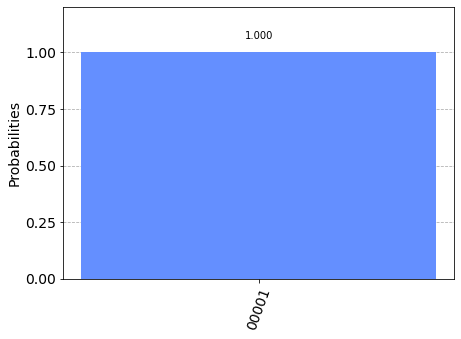

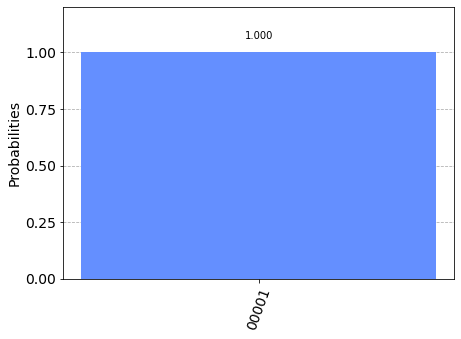

In [14]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(circuit, backend=simulator, shots=1000).result().get_counts(circuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

Use the measured counts to determine $\theta$. Fetch the outcome with the largest probability, and divide by $2^n$ since the quantum phase estimation algorithm outputs $2^n\theta$. Note also that the order of the bits in the outcome is reversed, since `Qiskit` uses the top-most outcome bit to come from the top-most qubit.

In [15]:
import operator
highest_probability_outcome = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
measured_theta = int(highest_probability_outcome, 2)/2**n
print("Using %d qubits with theta = %.2f, measured_theta = %f" % (n, theta, measured_theta))

Using 5 qubits with theta = 0.50, measured_theta = 0.500000


In [16]:
def get_pi_estimate(n_qubits):

    n=n_qubits
    circuit = QPE_pi(n)
    
    # run the job and get the results
    simulator = Aer.get_backend('qasm_simulator')
    counts = execute(circuit, backend=simulator, shots=10000).result().get_counts(circuit)

    # get the count that occurred most frequently
    highest_probability_outcome = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
    measured_theta = int(highest_probability_outcome, 2)/2**n
    
    return (1./(2*measured_theta))

In [17]:
# estimate pi using different numbers of qubits
nqb = list(range(2,12+1))
pi_computed = []
for nq in nqb:
    pi_temp=get_pi_estimate(nq)
    pi_computed.append(pi_temp)
    print(f"{nq} qubits, pi ≈ {pi_temp}")

2 qubits, pi ≈ 2.0
3 qubits, pi ≈ 4.0
4 qubits, pi ≈ 2.6666666666666665
5 qubits, pi ≈ 3.2
6 qubits, pi ≈ 3.2
7 qubits, pi ≈ 3.2
8 qubits, pi ≈ 3.1219512195121952
9 qubits, pi ≈ 3.1604938271604937
10 qubits, pi ≈ 3.1411042944785277
11 qubits, pi ≈ 3.1411042944785277
12 qubits, pi ≈ 3.1411042944785277


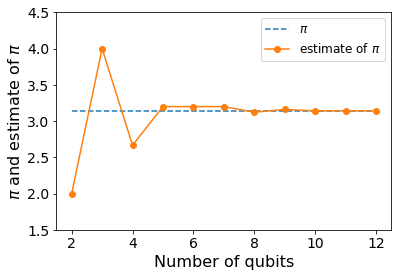

In [18]:
import matplotlib.pyplot as plt

pi = np.pi
plt.plot(nqb, [pi]*len(nqb), '--')
plt.plot(nqb, pi_computed, '.-',markersize=12)
plt.xlim([1.5, 12.5])
plt.ylim([1.5, 4.5])
plt.legend(['$\pi$', 'estimate of $\pi$'],fontsize=12)
plt.xlabel('Number of qubits', fontsize=16)
plt.ylabel('$\pi$ and estimate of $\pi$', fontsize=16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()